In [1]:
import numpy as np
np.random.seed(5)
import tensorflow as tf
tf.set_random_seed(15)
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'font.size': 16, # was 10
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
plt.rcParams.update(params)

In [2]:
# Generating training data that goes from initial condition location to PCA coefficient trajectory
num_modes=40
locs = np.load('../../SWE_Data/Data/Locations.npy')
pca_coeffs = np.load('../../SWE_Data/PCA_Coefficients_q1.npy')[0:num_modes,:]
coeff_scaler = MinMaxScaler()
pca_coeffs_scaled = coeff_scaler.fit_transform(np.transpose(pca_coeffs))

In [3]:
# The total shape is large due to multiple simulations
num_samples_total = np.shape(pca_coeffs_scaled)[0]
num_sims = int(num_samples_total/500)
pca_coeffs_scaled = np.reshape(pca_coeffs_scaled,newshape=(num_sims,500*40))

In [4]:
seq_num = 20
training_data_ip = np.copy(pca_coeffs_scaled[:,:40*(seq_num)])
training_data_ip = np.concatenate((training_data_ip,locs),axis=-1)
training_data_op = np.copy(pca_coeffs_scaled[:,40*(seq_num):])

In [5]:
from tensorflow.keras.layers import Input, Dense, Lambda, Add, LSTM, Dropout
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

In [6]:
weights_filepath = 'NA_MLP.h5'

def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [7]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [8]:
mlp_inputs = Input(shape=(40*seq_num+2),name='mlp_inputs')
h1 = Dense(148,activation='tanh')(mlp_inputs)
h2 = Dense(148,activation='tanh')(h1)
mlp_outputs = Dense((500-seq_num)*(40),activation=None)(h2)

mlp_model = Model(inputs=mlp_inputs,outputs=mlp_outputs)
 
# design network
my_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint,EarlyStoppingByLossVal()]

# fit network
mlp_model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination])    
mlp_model.summary()

W0126 18:25:34.698915 140564472837952 deprecation.py:506] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mlp_inputs (InputLayer)      [(None, 802)]             0         
_________________________________________________________________
dense (Dense)                (None, 148)               118844    
_________________________________________________________________
dense_1 (Dense)              (None, 148)               22052     
_________________________________________________________________
dense_2 (Dense)              (None, 19200)             2860800   
Total params: 3,001,696
Trainable params: 3,001,696
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 1000
batch_size = 4
train_mode = True

from time import time

start_time = time()
if train_mode:
    train_history = mlp_model.fit(x=training_data_ip, y=training_data_op, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list)
    np.save('NA_MLP.npy',train_history.history['loss'])
    
end_time = time()

Epoch 1/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.2669 - coeff_determination: -307.0498
Epoch 00001: loss improved from inf to 0.23450, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 7ms/sample - loss: 0.2345 - coeff_determination: -230.1008
Epoch 2/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.1609 - coeff_determination: -70.8842
Epoch 00002: loss improved from 0.23450 to 0.11563, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 0.1156 - coeff_determination: -46.1220
Epoch 3/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0552 - coeff_determination: -19.0383
Epoch 00003: loss improved from 0.11563 to 0.03131, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 0.0313 - coeff_determination: -10.4686
Epoch 4/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0123 - coeff_determination: -3.8092
Epoch 00004: lo

Epoch 63/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0084 - coeff_determination: -1.3467
Epoch 00063: loss did not improve from 0.00902
20/20 [==============================] - 0s 2ms/sample - loss: 0.0092 - coeff_determination: -1.4642
Epoch 64/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0084 - coeff_determination: -1.1811
Epoch 00064: loss did not improve from 0.00902
20/20 [==============================] - 0s 2ms/sample - loss: 0.0090 - coeff_determination: -1.3847
Epoch 65/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0085 - coeff_determination: -1.3373
Epoch 00065: loss did not improve from 0.00902
20/20 [==============================] - 0s 2ms/sample - loss: 0.0091 - coeff_determination: -1.5506
Epoch 66/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0090 - coeff_determination: -1.6402
Epoch 00066: loss did not improve from 0.00902
20/20 [==============================] - 0s 2ms/sample - loss: 0.0091 - c

 4/20 [=====>........................] - ETA: 0s - loss: 0.0069 - coeff_determination: -0.7296
Epoch 00122: loss improved from 0.00690 to 0.00683, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 0.0068 - coeff_determination: -0.4867
Epoch 123/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0075 - coeff_determination: -0.6779
Epoch 00123: loss improved from 0.00683 to 0.00665, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 2ms/sample - loss: 0.0066 - coeff_determination: -0.3223
Epoch 124/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0060 - coeff_determination: -0.0572
Epoch 00124: loss improved from 0.00665 to 0.00651, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 2ms/sample - loss: 0.0065 - coeff_determination: -0.3943
Epoch 125/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0063 - coeff_determination: -0.1816
Epoch 00125: loss improved

Epoch 179/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0030 - coeff_determination: 0.6756
Epoch 00179: loss improved from 0.00324 to 0.00321, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 0.0032 - coeff_determination: 0.6134
Epoch 180/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0032 - coeff_determination: 0.6472
Epoch 00180: loss improved from 0.00321 to 0.00320, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 0.0032 - coeff_determination: 0.6160
Epoch 181/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0025 - coeff_determination: 0.6837
Epoch 00181: loss did not improve from 0.00320
20/20 [==============================] - 0s 2ms/sample - loss: 0.0032 - coeff_determination: 0.6077
Epoch 182/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0024 - coeff_determination: 0.7661
Epoch 00182: loss improved from 0.00320 to 0.00319, s

Epoch 238/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0023 - coeff_determination: 0.7517
Epoch 00238: loss improved from 0.00210 to 0.00208, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 2ms/sample - loss: 0.0021 - coeff_determination: 0.7912
Epoch 239/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0016 - coeff_determination: 0.8321
Epoch 00239: loss improved from 0.00208 to 0.00207, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 2ms/sample - loss: 0.0021 - coeff_determination: 0.7965
Epoch 240/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0016 - coeff_determination: 0.8553
Epoch 00240: loss improved from 0.00207 to 0.00205, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 0.0021 - coeff_determination: 0.7933
Epoch 241/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0016 - coeff_determination: 0.8494
Epoch 00241: loss 

20/20 [==============================] - 0s 2ms/sample - loss: 0.0012 - coeff_determination: 0.8938
Epoch 297/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0012 - coeff_determination: 0.8828
Epoch 00297: loss improved from 0.00115 to 0.00114, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 0.0011 - coeff_determination: 0.8948
Epoch 298/1000
 4/20 [=====>........................] - ETA: 0s - loss: 0.0011 - coeff_determination: 0.8996
Epoch 00298: loss did not improve from 0.00114
20/20 [==============================] - 0s 2ms/sample - loss: 0.0012 - coeff_determination: 0.8912
Epoch 299/1000
 4/20 [=====>........................] - ETA: 0s - loss: 9.2514e-04 - coeff_determination: 0.9189
Epoch 00299: loss improved from 0.00114 to 0.00114, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 0.0011 - coeff_determination: 0.8946
Epoch 300/1000
 4/20 [=====>........................] - ET

Epoch 326/1000
 4/20 [=====>........................] - ETA: 0s - loss: 7.7105e-04 - coeff_determination: 0.9310
Epoch 00326: loss improved from 0.00083 to 0.00083, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 2ms/sample - loss: 8.2909e-04 - coeff_determination: 0.9253
Epoch 327/1000
 4/20 [=====>........................] - ETA: 0s - loss: 7.4609e-04 - coeff_determination: 0.9288
Epoch 00327: loss improved from 0.00083 to 0.00082, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 2ms/sample - loss: 8.1798e-04 - coeff_determination: 0.9273
Epoch 328/1000
 4/20 [=====>........................] - ETA: 0s - loss: 7.7386e-04 - coeff_determination: 0.9251
Epoch 00328: loss improved from 0.00082 to 0.00079, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 7.9213e-04 - coeff_determination: 0.9293
Epoch 329/1000
 4/20 [=====>........................] - ETA: 0s - loss: 8.5443e-04 - coeff_determinatio

20/20 [==============================] - 0s 3ms/sample - loss: 5.6994e-04 - coeff_determination: 0.9496
Epoch 356/1000
 4/20 [=====>........................] - ETA: 0s - loss: 6.3830e-04 - coeff_determination: 0.9443
Epoch 00356: loss did not improve from 0.00057
20/20 [==============================] - 0s 2ms/sample - loss: 5.7134e-04 - coeff_determination: 0.9496
Epoch 357/1000
 4/20 [=====>........................] - ETA: 0s - loss: 6.4596e-04 - coeff_determination: 0.9392
Epoch 00357: loss did not improve from 0.00057
20/20 [==============================] - 0s 2ms/sample - loss: 5.8850e-04 - coeff_determination: 0.9483
Epoch 358/1000
 4/20 [=====>........................] - ETA: 0s - loss: 5.6561e-04 - coeff_determination: 0.9489
Epoch 00358: loss did not improve from 0.00057
20/20 [==============================] - 0s 2ms/sample - loss: 5.7374e-04 - coeff_determination: 0.9492
Epoch 359/1000
 4/20 [=====>........................] - ETA: 0s - loss: 4.5751e-04 - coeff_determination

Epoch 414/1000
 4/20 [=====>........................] - ETA: 0s - loss: 4.3433e-04 - coeff_determination: 0.9620
Epoch 00414: loss did not improve from 0.00025
20/20 [==============================] - 0s 2ms/sample - loss: 3.6431e-04 - coeff_determination: 0.9694
Epoch 415/1000
 4/20 [=====>........................] - ETA: 0s - loss: 3.8593e-04 - coeff_determination: 0.9681
Epoch 00415: loss did not improve from 0.00025
20/20 [==============================] - 0s 2ms/sample - loss: 3.3082e-04 - coeff_determination: 0.9723
Epoch 416/1000
 4/20 [=====>........................] - ETA: 0s - loss: 2.5522e-04 - coeff_determination: 0.9780
Epoch 00416: loss did not improve from 0.00025
20/20 [==============================] - 0s 2ms/sample - loss: 3.0880e-04 - coeff_determination: 0.9743
Epoch 417/1000
 4/20 [=====>........................] - ETA: 0s - loss: 3.5585e-04 - coeff_determination: 0.9706
Epoch 00417: loss did not improve from 0.00025
20/20 [==============================] - 0s 2ms/

Epoch 444/1000
 4/20 [=====>........................] - ETA: 0s - loss: 1.0034e-04 - coeff_determination: 0.9915
Epoch 00444: loss did not improve from 0.00018
20/20 [==============================] - 0s 2ms/sample - loss: 2.2041e-04 - coeff_determination: 0.9818
Epoch 445/1000
 4/20 [=====>........................] - ETA: 0s - loss: 1.5814e-04 - coeff_determination: 0.9859
Epoch 00445: loss did not improve from 0.00018
20/20 [==============================] - 0s 2ms/sample - loss: 1.9280e-04 - coeff_determination: 0.9840
Epoch 446/1000
 4/20 [=====>........................] - ETA: 0s - loss: 7.1855e-05 - coeff_determination: 0.9946
Epoch 00446: loss improved from 0.00018 to 0.00017, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 1.7106e-04 - coeff_determination: 0.9856
Epoch 447/1000
 4/20 [=====>........................] - ETA: 0s - loss: 9.7248e-05 - coeff_determination: 0.9916
Epoch 00447: loss improved from 0.00017 to 0.00016, saving m

Epoch 474/1000
 4/20 [=====>........................] - ETA: 0s - loss: 2.4420e-05 - coeff_determination: 0.9981
Epoch 00474: loss improved from 0.00010 to 0.00009, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 2ms/sample - loss: 9.1318e-05 - coeff_determination: 0.9925
Epoch 475/1000
 4/20 [=====>........................] - ETA: 0s - loss: 1.1715e-04 - coeff_determination: 0.9899
Epoch 00475: loss improved from 0.00009 to 0.00009, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 3ms/sample - loss: 9.0437e-05 - coeff_determination: 0.9925
Epoch 476/1000
 4/20 [=====>........................] - ETA: 0s - loss: 1.2386e-04 - coeff_determination: 0.9890
Epoch 00476: loss improved from 0.00009 to 0.00008, saving model to NAT_MLP_PT.h5
20/20 [==============================] - 0s 2ms/sample - loss: 8.4937e-05 - coeff_determination: 0.9929
Epoch 477/1000
 4/20 [=====>........................] - ETA: 0s - loss: 9.2085e-05 - coeff_determinatio

 4/20 [=====>........................] - ETA: 0s - loss: 6.4011e-05 - coeff_determination: 0.9947
Epoch 00533: loss did not improve from 0.00004
20/20 [==============================] - 0s 2ms/sample - loss: 4.4902e-05 - coeff_determination: 0.9963
Epoch 534/1000
 4/20 [=====>........................] - ETA: 0s - loss: 6.4271e-05 - coeff_determination: 0.9947
Epoch 00534: loss did not improve from 0.00004
20/20 [==============================] - 0s 2ms/sample - loss: 4.3089e-05 - coeff_determination: 0.9965
Epoch 535/1000
 4/20 [=====>........................] - ETA: 0s - loss: 3.3164e-05 - coeff_determination: 0.9969
Epoch 00535: loss did not improve from 0.00004
20/20 [==============================] - 0s 2ms/sample - loss: 4.7218e-05 - coeff_determination: 0.9962
Epoch 536/1000
 4/20 [=====>........................] - ETA: 0s - loss: 9.5005e-05 - coeff_determination: 0.9924
Epoch 00536: loss did not improve from 0.00004
20/20 [==============================] - 0s 2ms/sample - loss: 

Epoch 563/1000
 4/20 [=====>........................] - ETA: 0s - loss: 1.7914e-05 - coeff_determination: 0.9985
Epoch 00563: loss did not improve from 0.00002
20/20 [==============================] - 0s 2ms/sample - loss: 2.4826e-05 - coeff_determination: 0.9979
Epoch 564/1000
 4/20 [=====>........................] - ETA: 0s - loss: 2.9035e-05 - coeff_determination: 0.9977
Epoch 00564: loss did not improve from 0.00002
20/20 [==============================] - 0s 1ms/sample - loss: 2.5430e-05 - coeff_determination: 0.9979
Epoch 565/1000
 4/20 [=====>........................] - ETA: 0s - loss: 1.1490e-05 - coeff_determination: 0.9991
Epoch 00565: loss did not improve from 0.00002
20/20 [==============================] - 0s 2ms/sample - loss: 2.3881e-05 - coeff_determination: 0.9980
Epoch 566/1000
 4/20 [=====>........................] - ETA: 0s - loss: 1.1123e-05 - coeff_determination: 0.9991
Epoch 00566: loss did not improve from 0.00002
20/20 [==============================] - 0s 2ms/

 4/20 [=====>........................] - ETA: 0s - loss: 1.6751e-04 - coeff_determination: 0.9864
Epoch 00594: loss did not improve from 0.00002
20/20 [==============================] - 0s 2ms/sample - loss: 1.5143e-04 - coeff_determination: 0.9877
Epoch 595/1000
 4/20 [=====>........................] - ETA: 0s - loss: 1.4541e-04 - coeff_determination: 0.9886
Epoch 00595: loss did not improve from 0.00002
20/20 [==============================] - 0s 2ms/sample - loss: 1.6117e-04 - coeff_determination: 0.9870
Epoch 596/1000
 4/20 [=====>........................] - ETA: 0s - loss: 2.7368e-04 - coeff_determination: 0.9774
Epoch 00596: loss did not improve from 0.00002
20/20 [==============================] - 0s 2ms/sample - loss: 1.5090e-04 - coeff_determination: 0.9877
Epoch 597/1000
 4/20 [=====>........................] - ETA: 0s - loss: 9.8950e-05 - coeff_determination: 0.9927
Epoch 00597: loss did not improve from 0.00002
20/20 [==============================] - 0s 2ms/sample - loss: 

In [10]:
print('Time elapsed:',end_time-start_time)

Time elapsed: 28.144092082977295


In [9]:
# Testing
mlp_model.load_weights(weights_filepath)
plt_array = np.arange(500,dtype='int')


filename = '../../SWE_Data/Data/snapshot_matrix_pod_test.npy'
test_data = np.load(filename)[0:64*64,:]
pca_vectors = np.load('../../SWE_Data/PCA_Vectors_q1.npy')[:,:num_modes]

true_pca_evol = coeff_scaler.transform(np.matmul(np.transpose(test_data),pca_vectors))
test_data = np.reshape(np.copy(true_pca_evol),newshape=(1,500*40))

test_inputs = np.copy(test_data[:,:40*seq_num])
test_outputs = np.copy(test_data[:,40*seq_num:])

test_locs = np.zeros(shape=(1,2))
test_locs[0,0] = -1.0/2.7
test_locs[0,1] = -1.0/4.0

test_inputs = np.concatenate((test_inputs,test_locs),axis=-1)

In [10]:
pred_pca = mlp_model.predict(test_inputs)
pred_pca = np.concatenate((test_inputs[:,:800],pred_pca),axis=-1)

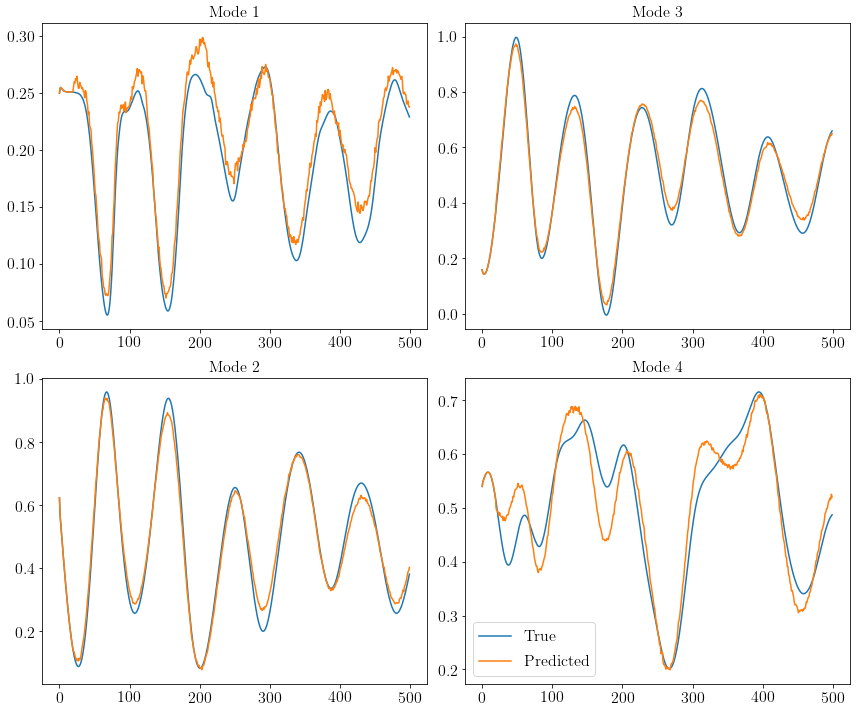

In [11]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,10))
mode_num = 0
ax[0,0].plot(test_data[0,plt_array*(40)+mode_num],label='True')
ax[0,0].plot(pred_pca[0,plt_array*(40)+mode_num],label='Predicted')
ax[0,0].set_title('Mode 1')

mode_num = 1
ax[1,0].plot(test_data[0,plt_array*(40)+mode_num],label='True')
ax[1,0].plot(pred_pca[0,plt_array*(40)+mode_num],label='Predicted')
ax[1,0].set_title('Mode 2')

mode_num = 2
ax[0,1].plot(test_data[0,plt_array*(40)+mode_num],label='True')
ax[0,1].plot(pred_pca[0,plt_array*(40)+mode_num],label='Predicted')
ax[0,1].set_title('Mode 3')

mode_num = 3
ax[1,1].plot(test_data[0,plt_array*(40)+mode_num],label='True')
ax[1,1].plot(pred_pca[0,plt_array*(40)+mode_num],label='Predicted')
ax[1,1].set_title('Mode 4')

plt.tight_layout()
plt.legend()
plt.show()

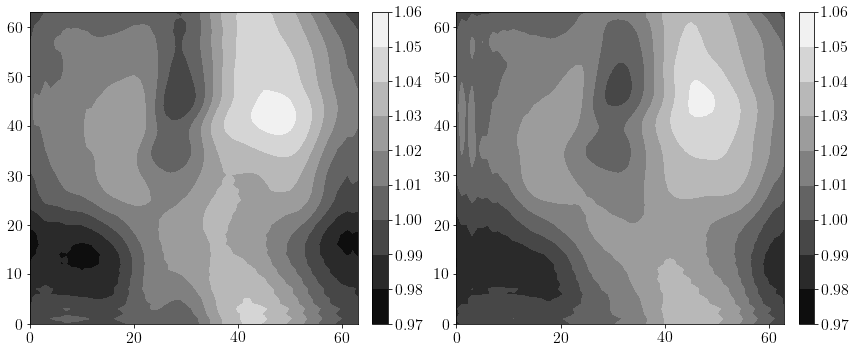

In [12]:
# Plotting some contours
# True field
true_rb = np.transpose(coeff_scaler.inverse_transform(true_pca_evol))
true_recon = np.matmul(pca_vectors,true_rb)[:,-1].reshape(64,64)

pred_rb = pred_pca[0,:].reshape(500,40)
pred_rb = np.transpose(coeff_scaler.inverse_transform(pred_rb))
pred_recon = np.matmul(pca_vectors,pred_rb)[:,-1].reshape(64,64)


fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
cx = ax[0].contourf(true_recon)
ax[1].contourf(pred_recon)

fig.colorbar(cx,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(cx,ax=ax[1],fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [14]:
np.save('../Figures/NA_MLP_Preds.npy',pred_pca)
np.save('../Figures/NA_MLP_Fields.npy',pred_recon)